In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import itertools
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
profiles = {
    "ORF": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "CRISPR": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected",
}

color_discrete_map = {
    "ORF": "rgb(0, 158, 115)",
    "CRISPR": "rgb(213, 94, 0)",
}

gene_labels = {
    "Protein Class": "protein_class",
    "Disease Association": "disease_association",
    "CORUM Complex": "corum_complex",
    "Wikipathway": "wikipathway",
    "HGNC Gene Group": "gene-group",
}

label_columns = {
    "Protein Class": "Metadata_protein_class_list",
    "Disease Association": "Metadata_disease_list",
    "CORUM Complex": "Metadata_corum_complex_list",
    "Wikipathway": "Metadata_wikipathway_list",
    "HGNC Gene Group": "Metadata_gene_group_list",
}

Read phenotypic activity data

In [3]:
phenotypic_activity_df = pd.DataFrame()

for profile in profiles:
    df = pd.read_csv(f"output/phenotypic-activity-{profiles[profile]}.csv.gz")
    df["profile_type"] = profile
    phenotypic_activity_df = pd.concat(
        [phenotypic_activity_df, df], ignore_index=True, axis=0
    )

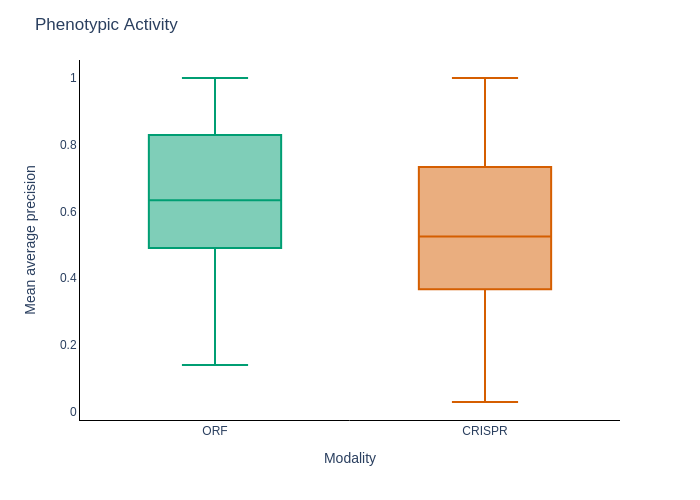

In [4]:
fig = px.box(
    phenotypic_activity_df,
    x="profile_type",
    y="mean_average_precision",
    color="profile_type",
    color_discrete_map=color_discrete_map,
).update_layout(
    title="Phenotypic Activity",
    xaxis=dict(title="Modality", linecolor="black"),
    yaxis=dict(title="Mean average precision", linecolor="black"),
    plot_bgcolor="white",
    showlegend=False,
)

fig.show("png")

In [5]:
fraction_retrieved = (
    phenotypic_activity_df.groupby("profile_type")
    .below_corrected_p.apply(lambda x: (x == True).sum() / len(x))
    .reset_index()
    .rename(columns={"below_corrected_p": "fraction_retrieved"})
)

print(fraction_retrieved.to_markdown(index=False))

| profile_type   |   fraction_retrieved |
|:---------------|---------------------:|
| CRISPR         |             0.695772 |
| ORF            |             0.568964 |


In [6]:
n_retrieved = (
    phenotypic_activity_df.groupby("profile_type")
    .below_corrected_p.apply(lambda x: (x == True).sum())
    .reset_index()
    .rename(columns={"below_corrected_p": "n_retrieved"})
)

print(n_retrieved.to_markdown(index=False))

| profile_type   |   n_retrieved |
|:---------------|--------------:|
| CRISPR         |          5546 |
| ORF            |          7817 |


In [7]:
gene_label_retrieval_df = pd.DataFrame()

for gene_label in gene_labels:
    df = (
        pd.read_parquet(f"output/{gene_labels[gene_label]}_retrieval.parquet")[
            ["mean_average_precision", "below_corrected_p", "Modality", "p_value", "corrected_p_value"]
        ]
        .assign(gene_label=gene_label)
    )
    gene_label_retrieval_df = pd.concat(
        [gene_label_retrieval_df, df], ignore_index=True, axis=0
    )

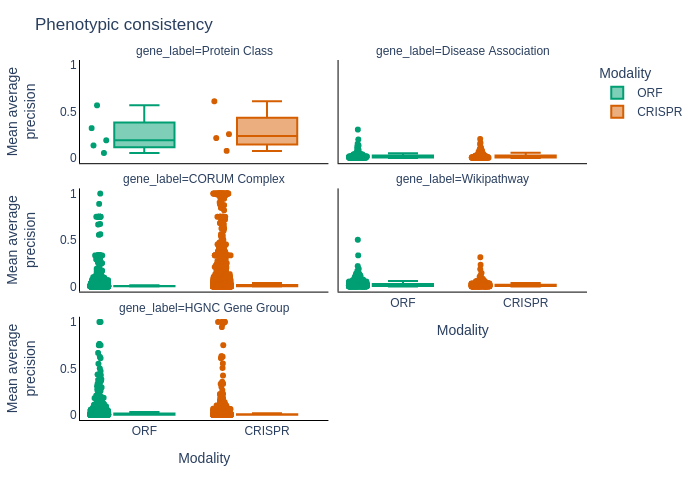

In [8]:
fig = (
    px.box(
        gene_label_retrieval_df,
        x="Modality",
        y="mean_average_precision",
        color="Modality",
        color_discrete_map=color_discrete_map,
        facet_col="gene_label",
        facet_col_wrap=2,
        points="all",
    )
    .update_layout(
        title="Phenotypic consistency",
        xaxis1=dict(title="Modality",linecolor="black"),
        xaxis3=dict(linecolor="black"),
        xaxis4=dict(title="Modality", linecolor="black", showticklabels=True),
        xaxis5=dict(linecolor="black"),
        xaxis6=dict(linecolor="black"),
        yaxis1=dict(title=f"Mean average<br>precision", linecolor="black"),
        yaxis3=dict(title=f"Mean average<br>precision", linecolor="black"),
        yaxis4=dict(linecolor="black"),
        yaxis5=dict(title=f"Mean average<br>precision",linecolor="black"),
        yaxis6=dict(linecolor="black"),
        plot_bgcolor="white",
    )
)

fig.show("png")

In [9]:
print(
    gene_label_retrieval_df.query("below_corrected_p == True")
    .groupby(["Modality", "gene_label"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="Modality", columns="gene_label", values="mean_average_precision")
    .sort_index()
    [list(gene_labels.keys())]
    .fillna(0)
    .to_markdown()
)

| Modality   |   Protein Class |   Disease Association |   CORUM Complex |   Wikipathway |   HGNC Gene Group |
|:-----------|----------------:|----------------------:|----------------:|--------------:|------------------:|
| CRISPR     |               0 |                     3 |             317 |           154 |                88 |
| ORF        |               5 |                     2 |              45 |           346 |               196 |


In [10]:
common_labels_df = pd.DataFrame()

for gene_label in gene_labels:
    df = pd.read_parquet(f"output/{gene_labels[gene_label]}_retrieval.parquet")[
        [f"{label_columns[gene_label]}", "below_corrected_p", "Modality", "p_value", "corrected_p_value"]
    ]
    orf_df = df.query("Modality == 'ORF' and below_corrected_p == True")
    crispr_df = df.query("Modality == 'CRISPR' and below_corrected_p == True")
    merged_df = orf_df.merge(crispr_df, on=f"{label_columns[gene_label]}", how="inner")

    common_labels_df = pd.concat(
        [
            common_labels_df,
            pd.DataFrame(
                {
                    "ORF": len(orf_df),
                    "CRISPR": len(crispr_df),
                    "Common": len(merged_df),
                },
                index=[gene_label],
            ),
        ],
        axis=0,
    )

print(common_labels_df.to_markdown())

|                     |   ORF |   CRISPR |   Common |
|:--------------------|------:|---------:|---------:|
| Protein Class       |     5 |        0 |        0 |
| Disease Association |     2 |        3 |        0 |
| CORUM Complex       |    45 |      317 |        6 |
| Wikipathway         |   346 |      154 |       83 |
| HGNC Gene Group     |   196 |       88 |       13 |


In [11]:
phenotypic_activity_consistency_df = pd.concat(
    [
        phenotypic_activity_df[["profile_type", "mean_average_precision", "below_corrected_p"]]
        .assign(retrieval="Replicates")
        .rename(columns={"profile_type": "Modality"}),
        gene_label_retrieval_df[["Modality", "mean_average_precision", "gene_label", "below_corrected_p"]].rename(
            columns={"gene_label": "retrieval"}
        ),
    ],
    ignore_index=True,
)

In [12]:
# Number of points per plot
n_points_df = (
    phenotypic_activity_consistency_df.groupby(["retrieval", "Modality"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="retrieval", columns="Modality", values="mean_average_precision")
    .reset_index()
)

In [13]:
n_retrieved_df = (
    phenotypic_activity_consistency_df.query("below_corrected_p == True")
    .groupby(["Modality", "retrieval"])
    .mean_average_precision.count()
    .reset_index()
    .pivot(index="retrieval", columns="Modality", values="mean_average_precision")
).fillna(0)

n_retrieved_df = n_retrieved_df.astype(int).reset_index()
n_retrieved_df = n_retrieved_df.rename(
    columns={"ORF": "ORF_retrieved", "CRISPR": "CRISPR_retrieved"}
)

In [14]:
facet_text_df = (
    n_points_df.merge(n_retrieved_df, on="retrieval", how="inner")
    .assign(orf_fraction=lambda x: x["ORF_retrieved"] / x["ORF"])
    .assign(crispr_fraction=lambda x: x["CRISPR_retrieved"] / x["CRISPR"])
    .assign(
        text=lambda x: x.apply(
            lambda y: f"{y['retrieval']}<br>ORF: {y['ORF_retrieved']}/{y['ORF']} = {y['orf_fraction']:.2f}<br>CRISPR: {y['CRISPR_retrieved']}/{y['CRISPR']} = {y['crispr_fraction']:.2f}",
            axis=1,
        )
    )
)

facet_text_df

Modality,retrieval,CRISPR,ORF,CRISPR_retrieved,ORF_retrieved,orf_fraction,crispr_fraction,text
0,CORUM Complex,1762,1314,317,45,0.034247,0.179909,CORUM Complex<br>ORF: 45/1314 = 0.03<br>CRISPR...
1,Disease Association,119,123,3,2,0.016260,0.025210,Disease Association<br>ORF: 2/123 = 0.02<br>CR...
2,HGNC Gene Group,777,947,88,196,0.206969,0.113256,HGNC Gene Group<br>ORF: 196/947 = 0.21<br>CRIS...
3,Protein Class,4,5,0,5,1.000000,0.000000,Protein Class<br>ORF: 5/5 = 1.00<br>CRISPR: 0/...
4,Replicates,7971,13739,5546,7817,0.568964,0.695772,Replicates<br>ORF: 7817/13739 = 0.57<br>CRISPR...
5,Wikipathway,783,770,154,346,0.449351,0.196679,Wikipathway<br>ORF: 346/770 = 0.45<br>CRISPR: ...


In [15]:
min_max_df = (
    phenotypic_activity_consistency_df.groupby(
        ["retrieval", "Modality", "below_corrected_p"]
    )
    .mean_average_precision.apply(
        lambda x: [np.percentile(x, 10), np.percentile(x, 90)]
    )
    .reset_index()
    .rename(columns={"mean_average_precision": "min_max"})
)

min_max_df.below_corrected_p = min_max_df.below_corrected_p.map({True: "True", False: "False"})

missing_rows = pd.DataFrame(
    {
        "retrieval": ["Protein Class", "Protein Class"],
        "Modality": ["ORF", "CRISPR"],
        "below_corrected_p": ["False", "True"],
        "min_max": [[0.0, 0.0], [0.0, 0.0]],
    }
)

min_max_df = pd.concat([min_max_df, missing_rows], ignore_index=True)

min_max_df.sort_values(["retrieval", "Modality", "below_corrected_p"], inplace=True)

min_max_df

,retrieval,Modality,below_corrected_p,min_max
0,CORUM Complex,CRISPR,False,"[0.000727371975333115, 0.013443886196908587]"
1,CORUM Complex,CRISPR,True,"[0.06380961246905564, 1.0]"
2,CORUM Complex,ORF,False,"[0.0007097733857876245, 0.01700129308902018]"
3,CORUM Complex,ORF,True,"[0.09661427308554317, 0.75]"
4,Disease Association,CRISPR,False,"[0.002804453531063836, 0.046395185019474906]"
5,Disease Association,CRISPR,True,"[0.08206140095984818, 0.1492624152635481]"
6,Disease Association,ORF,False,"[0.002683094472334282, 0.04241899296531094]"
7,Disease Association,ORF,True,"[0.210659882718527, 0.29610601722050645]"
8,HGNC Gene Group,CRISPR,False,"[0.00035541838936648874, 0.01049521424469527]"
9,HGNC Gene Group,CRISPR,True,"[0.03523400928238004, 0.9543611111111109]"


In [16]:
min_max_df = (
    min_max_df.groupby(["retrieval", "Modality"])
    .min_max.apply(lambda x: [list(x)[0][1], list(x)[1][0]])
    .reset_index()
)

min_max_df

,retrieval,Modality,min_max
0,CORUM Complex,CRISPR,"[0.013443886196908587, 0.06380961246905564]"
1,CORUM Complex,ORF,"[0.01700129308902018, 0.09661427308554317]"
2,Disease Association,CRISPR,"[0.046395185019474906, 0.08206140095984818]"
3,Disease Association,ORF,"[0.04241899296531094, 0.210659882718527]"
4,HGNC Gene Group,CRISPR,"[0.01049521424469527, 0.03523400928238004]"
5,HGNC Gene Group,ORF,"[0.009566772223526303, 0.021043808862246216]"
6,Protein Class,CRISPR,"[0.5048386112833331, 0.0]"
7,Protein Class,ORF,"[0.0, 0.08695819989913708]"
8,Replicates,CRISPR,"[0.4043899736239889, 0.4345562247144727]"
9,Replicates,ORF,"[0.576856092436975, 0.6174880952380952]"


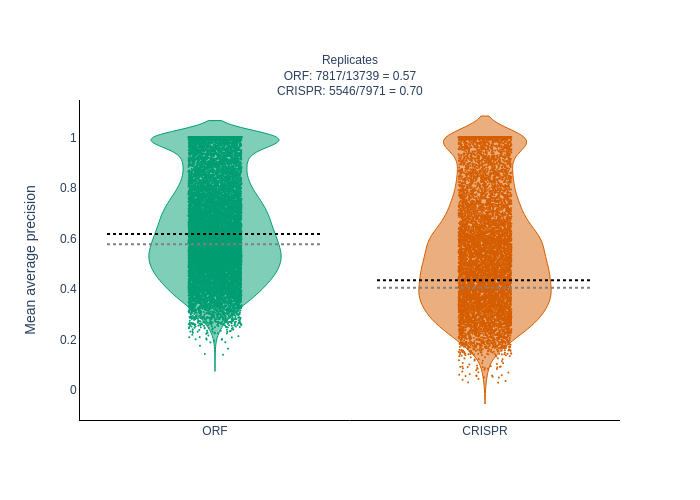

In [17]:
category_order = {
    "retrieval": [
        "Replicates",
    ]
}

fig = make_subplots(
    rows=1,
    cols=len(category_order["retrieval"]),
    column_titles=category_order["retrieval"],
)

for i in range(len(category_order["retrieval"])):
    category = category_order["retrieval"][i]
    for modality in ["ORF", "CRISPR"]:
        subset_data = phenotypic_activity_consistency_df.query(
            "retrieval == @category & Modality == @modality"
        )
        fig.add_trace(
            go.Violin(
                y=subset_data["mean_average_precision"],
                name=modality,
                showlegend=False,
                points="all",
                pointpos=0,
                line_color=color_discrete_map[modality],
                line_width=1,
                jitter=0.4,
                marker_size=2,
            ),
            row=1,
            col=i + 1,
        )

fig.update_layout(
    xaxis=dict(title="", linecolor="black"),
    yaxis=dict(title=f"Mean average precision", linecolor="black"),
    plot_bgcolor="white",
)

fig.for_each_annotation(lambda x: x.update(text=facet_text_df.text[facet_text_df.retrieval == x.text].values[0]))
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 12

for label, idx in zip(
    category_order["retrieval"], itertools.product([1], [1, 2, 3, 4, 5])
):
    min_max = min_max_df.query(
        "retrieval == @label and Modality == 'ORF'"
    ).min_max.values
    y_false_max = min_max[0][0]
    y_true_min = min_max[0][1]
    fig.add_shape(
        type="line",
        x0=-0.4,
        x1=0.4,
        y0=y_false_max,
        y1=y_false_max,
        line=dict(dash="dot", color="grey"),
        row=idx[0],
        col=idx[1],
    )

    fig.add_shape(
        type="line",
        x0=-0.4,
        x1=0.4,
        y0=y_true_min,
        y1=y_true_min,
        line=dict(dash="dot", color="black"),
        row=idx[0],
        col=idx[1],
    )

    min_max = min_max_df.query(
        "retrieval == @label and Modality == 'CRISPR'"
    ).min_max.values
    y_false_max = min_max[0][0]
    y_true_min = min_max[0][1]

    fig.add_shape(
        type="line",
        x0=0.6,
        x1=1.4,
        y0=y_false_max,
        y1=y_false_max,
        line=dict(dash="dot", color="grey"),
        row=idx[0],
        col=idx[1],
    )

    fig.add_shape(
        type="line",
        x0=0.6,
        x1=1.4,
        y0=y_true_min,
        y1=y_true_min,
        line=dict(dash="dot", color="black"),
        row=idx[0],
        col=idx[1],
    )

fig.show("png")

fig.write_image(
    "figures/phenotypic-activity.png", height=320, width=320, scale=2
)
fig.write_image(
    "figures/phenotypic-activity.svg", height=320, width=320, scale=2
)

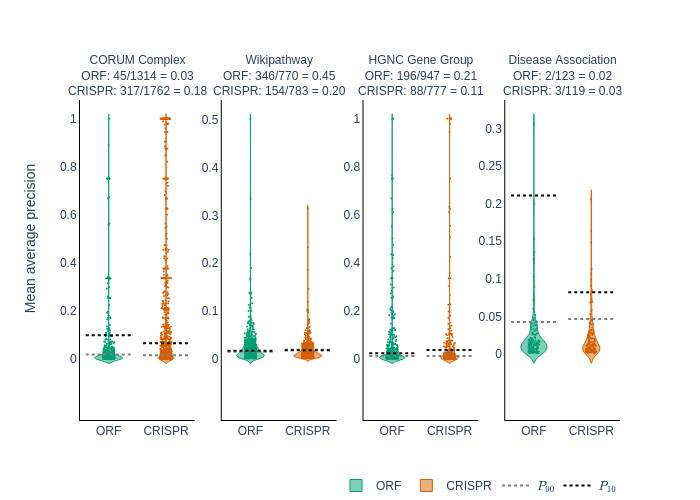

In [18]:
category_order = {
    "retrieval": [
        "CORUM Complex",
        "Wikipathway",
        "HGNC Gene Group",
        "Disease Association",
    ]
}

fig = make_subplots(
    rows=1,
    cols=len(category_order["retrieval"]),
    column_titles=category_order["retrieval"],
)

for i in range(len(category_order["retrieval"])):
    category = category_order["retrieval"][i]
    for modality in ["ORF", "CRISPR"]:
        subset_data = phenotypic_activity_consistency_df.query(
            "retrieval == @category & Modality == @modality"
        )
        fig.add_trace(
            go.Violin(
                y=subset_data["mean_average_precision"],
                name=modality,
                showlegend=i == 0,
                points="all",
                pointpos=0,
                line_color=color_discrete_map[modality],
                line_width=1,
                jitter=0.4,
                marker_size=2,
            ),
            row=1,
            col=i + 1,
        )

fig.update_layout(
    xaxis1=dict(title="", linecolor="black"),
    xaxis2=dict(title="", linecolor="black"),
    xaxis3=dict(title="", linecolor="black"),
    xaxis4=dict(title="", linecolor="black"),
    yaxis1=dict(title=f"Mean average precision", linecolor="black"),
    yaxis2=dict(linecolor="black"),
    yaxis3=dict(linecolor="black"),
    yaxis4=dict(linecolor="black"),
    plot_bgcolor="white",
)

fig.for_each_annotation(lambda x: x.update(text=facet_text_df.text[facet_text_df.retrieval == x.text].values[0]))
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 12

for label, idx in zip(
    category_order["retrieval"], itertools.product([1], [1, 2, 3, 4, 5])
):
    min_max = min_max_df.query(
        "retrieval == @label and Modality == 'ORF'"
    ).min_max.values
    y_false_max = min_max[0][0]
    y_true_min = min_max[0][1]
    fig.add_shape(
        type="line",
        x0=-0.4,
        x1=0.4,
        y0=y_false_max,
        y1=y_false_max,
        line=dict(dash="dot", color="grey"),
        row=idx[0],
        col=idx[1],
    )

    fig.add_shape(
        type="line",
        x0=-0.4,
        x1=0.4,
        y0=y_true_min,
        y1=y_true_min,
        line=dict(dash="dot", color="black"),
        row=idx[0],
        col=idx[1],
    )

    min_max = min_max_df.query(
        "retrieval == @label and Modality == 'CRISPR'"
    ).min_max.values
    y_false_max = min_max[0][0]
    y_true_min = min_max[0][1]

    fig.add_shape(
        type="line",
        x0=0.6,
        x1=1.4,
        y0=y_false_max,
        y1=y_false_max,
        line=dict(dash="dot", color="grey"),
        row=idx[0],
        col=idx[1],
    )

    fig.add_shape(
        type="line",
        x0=0.6,
        x1=1.4,
        y0=y_true_min,
        y1=y_true_min,
        line=dict(dash="dot", color="black"),
        row=idx[0],
        col=idx[1],
    )

# Adding invisible lines for the legend
fig.add_scatter(
    x=["ORF", "ORF"],
    y=[y_false_max, y_false_max],
    mode="lines",
    line=dict(dash="dot", color="grey"),
    name=f"$P_{{{90}}}$",
    showlegend=True,
    row=1,
    col=1,
)

fig.add_scatter(
    x=["ORF", "ORF"],
    y=[y_true_min, y_true_min],
    mode="lines",
    line=dict(dash="dot", color="black"),
    name=f"$P_{{{10}}}$",
    showlegend=True,
    row=1,
    col=1,
)

fig.update_layout(legend=dict(
    yanchor="bottom",
    orientation="h",
    y=-0.4,
    xanchor="right",
    x=1,
    title="",
))

fig.show("png")

fig.write_image(
    "figures/phenotypic-consistency.png", height=320, width=768, scale=2
)
fig.write_image(
    "figures/phenotypic-consistency.svg", height=320, width=768, scale=2
)

In [19]:
phenotypic_activity_consistency_df = pd.concat(
    [
        phenotypic_activity_df[
            [
                "profile_type",
                "mean_average_precision",
                "p_value",
                "corrected_p_value",
                "below_corrected_p",
            ]
        ]
        .assign(retrieval="Replicates")
        .rename(columns={"profile_type": "Modality"}),
        gene_label_retrieval_df[
            [
                "Modality",
                "mean_average_precision",
                "gene_label",
                "p_value",
                "corrected_p_value",
                "below_corrected_p",
            ]
        ].rename(columns={"gene_label": "retrieval"}),
    ],
    ignore_index=True,
)

In [20]:
phenotypic_activity_consistency_df.to_parquet("output/phenotypic-activity-consistency.parquet", index=False)